# Notebook 06 - VolSense Model Explainability

This notebook produces two forms of model explainability for the `GlobalVolForecaster` volatility model (model v507):

1. **Feature Sensitivity (Bump Test)**  
   For each input feature, we apply a small controlled shock (±ε) to that feature across the most recent 40-day window and measure how much the model's 1-day / 5-day / 10-day forecast changes.  
   This answers: *"Which features actually move the forecast if the world changes a little?"*

2. **Temporal Attention Heatmap**  
   We visualize which days in the 40-day lookback window the model attends to most strongly when producing forecasts.  
   This answers: *"Which specific past days mattered most for this ticker today?"*

## Why not SHAP / Integrated Gradients?

Most classical attribution tools assume:
- A single flat input vector.
- One model forward pass that is a clean, differentiable mapping `y = f(x)`.

Our model is not that:
- Inputs are **two-headed**:  
  - A time series window `X ∈ ℝ[window, num_features]`  
  - A categorical ticker embedding `ticker_idx ∈ ℤ[1,3]` (3-token per ticker encoding)
- The model does:
  - Feature dropout (noise-injection / masking),
  - Variational dropout,
  - LSTM over time,
  - Multihead self-attention over hidden states,
  - Multi-head MLP decoders *plus* a residual linear shortcut.

Because of that:
- SHAP tries to treat the whole thing as `f(flat_vector)`, fails, or produces nonsense because it can't factor the frozen ticker embedding path and the temporal mixing in attention.
- Integrated Gradients expects to interpolate between a baseline and the real input. But interpolating categorical ticker IDs across ℝ is meaningless, and if you try to leave tickers fixed you break the “path integral completeness” guarantee — which is why it gave you empty / NaN attributions.

So instead of forcing a those tools, we’re using attribution methods that respect how the model is actually structured:
- **Bump Test = causal sensitivity** (feature → output delta)
- **Attention Heatmap = temporal focus** (which timestamps matter)

## Imports and Setup

In [12]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from volsense_inference.model_loader import load_model
from volsense_core.models.global_vol_forecaster import TrainConfig, build_global_splits

# Make plots a bit nicer / readable for screenshots
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Device (we'll stay on CPU for reproducibility in docs)
DEVICE = "cpu"

## Load v507 Checkpoint + training data

We load the frozen v507 model weights and scalers for inference.

In [14]:
# Load trained model + metadata

model, meta, scalers, ticker_to_idx, features_from_checkpoint = load_model(
    'v507', 
    checkpoints_dir='../models'
)
window = 40

model.eval()
model.to(DEVICE)

# Load the full pre-built dataset you used for training
full_df = pd.read_csv("../data/processed/master_lstm_dataset.csv")

print("Loaded model + data.")
print("Model horizons:", meta.get("horizons", "N/A"))
print("Model window:", window)
print("First few columns in full_df:", list(full_df.columns)[:10])

Loaded model + data.
Model horizons: [1, 5, 10]
Model window: 40
First few columns in full_df: ['Unnamed: 0', 'ticker', 'date', 'return', 'realized_vol_log', 'realized_vol', 'ewma_vol_10d', 'ret_sq', 'vol_10d', 'vol_chg']


## Rebuild the training config used in v507 model training

In [15]:
HORIZONS = [1, 5, 10]
EXTRA_FEATURES = [
    "vol_3d", "vol_10d", "vol_ratio", "vol_chg", "vol_vol",
    "ewma_vol_10d", "market_stress", "market_stress_1d_lag",
    "skew_5d", "abs_return"
]

cfg = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=3,
    val_start="2023-10-10",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    epochs=30,
    lr=2.5e-4,
    batch_size=256,
    cosine_schedule=True,
    oversample_high_vol=False,
    device="cpu",
    dropout=0.35,
    use_layernorm=True,
    separate_heads=True,
    loss_horizon_weights=[0.5, 0.3, 0.2],
    dynamic_window_jitter=5,
    grad_clip=1.0,
    num_workers=0,
    pin_memory=False,
)

# Build the same-style dataset splits you used to train
train_ds, val_ds, scalers_from_split, idx_map = build_global_splits(
    df=full_df,
    cfg=cfg
)

print("train_ds length:", len(train_ds))
print("val_ds length:", len(val_ds))


train_ds length: 698086
val_ds length: 77913


## Helper to pull one clean (ticker, window) sample

We’re going to:

- pick a ticker (say AAPL),

- take the last available 40-day window for that ticker from full_df,

- scale it and turn it into tensors exactly like training,

- build the ticker index tensor in the format the model expects.

- This is what we’ll feed to both the bump test and attention heatmap.

## Prepare a ticker sample & rebuild scaling proxy

In [24]:
from volsense_core.utils.scalers import TorchStandardScaler as StandardScaler

def prepare_single_ticker_window(
    df: pd.DataFrame,
    ticker: str,
    cfg: TrainConfig,
    idx_map_or_dict: dict,
    meta: dict
):
    """
    Rebuild a single ticker's last window as model input.
    Uses on-the-fly z-score scaling since scalers aren't saved.
    """
    # --- Extract the ticker subset ---
    df_tkr = df[df["ticker"] == ticker].sort_values("date").copy()
    if len(df_tkr) < cfg.window:
        raise ValueError(f"{ticker} has insufficient history ({len(df_tkr)}) for window={cfg.window}.")
    df_tkr = df_tkr.tail(cfg.window)

    # --- Determine features ---
    feature_names = ["return"] + (cfg.extra_features or meta.get("features", []))
    X_raw = df_tkr[feature_names].values

    # --- Proxy normalization (since original scalers weren't persisted) ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    # --- Convert to tensors ---
    x_input = X_scaled.detach().clone().unsqueeze(0).to(torch.float32).to(DEVICE)

    # --- Build ticker index tensor ---
    if isinstance(idx_map_or_dict, dict):
        t_idx = idx_map_or_dict.get(ticker, 0)
    else:
        t_idx = 0
    ticker_idx = torch.tensor([[t_idx]], dtype=torch.long, device=DEVICE)
    ticker_idx = ticker_idx.view(-1)

    print(f"[prepare] ticker={ticker} | x_input={x_input.shape} | ticker_idx={ticker_idx.shape}")
    return x_input, ticker_idx, feature_names

ticker = "AAPL"
x_input, ticker_idx, feature_names = prepare_single_ticker_window(
    full_df, ticker, cfg, meta.get("ticker_to_id", {}), meta
)

[prepare] ticker=AAPL | x_input=torch.Size([1, 40, 11]) | ticker_idx=torch.Size([1])


## Baseline prediction (for all horizons)

In [25]:
@torch.no_grad()
def predict_all_horizons(model, ticker_idx, x_input):
    model.eval()
    out = model(ticker_idx, x_input)
    return out.squeeze(0).cpu().numpy()

baseline_pred = predict_all_horizons(model, ticker_idx, x_input)
print(f"Ticker: {ticker}")
for h_i, h in enumerate(cfg.horizons):
    print(f"Horizon {h}d forecast (log-vol): {baseline_pred[h_i]:.4f}")

Ticker: AAPL
Horizon 1d forecast (log-vol): -1.1547
Horizon 5d forecast (log-vol): -1.0698
Horizon 10d forecast (log-vol): -1.0901


## Feature bump-test sensitivity

In [26]:
def bump_test(model, x_input, ticker_idx, feature_names, eps=0.05):
    base_pred = predict_all_horizons(model, ticker_idx, x_input)
    sensitivity = {}

    for feat_i, fname in enumerate(feature_names):
        x_plus = x_input.clone()
        x_minus = x_input.clone()
        x_plus[:, :, feat_i] += eps
        x_minus[:, :, feat_i] -= eps

        pred_plus = predict_all_horizons(model, ticker_idx, x_plus)
        pred_minus = predict_all_horizons(model, ticker_idx, x_minus)
        delta = (pred_plus - pred_minus) / 2.0
        sensitivity[fname] = {f"{h}d": float(delta[i]) for i, h in enumerate(cfg.horizons)}

    return base_pred, sensitivity

baseline_pred, sensitivity = bump_test(model, x_input, ticker_idx, feature_names)
print("Example sensitivity for 'return':", sensitivity["return"])

Example sensitivity for 'return': {'1d': -0.0005501508712768555, '5d': -0.00417935848236084, '10d': -0.0070917606353759766}


## Plot 1-day horizon sensitivity

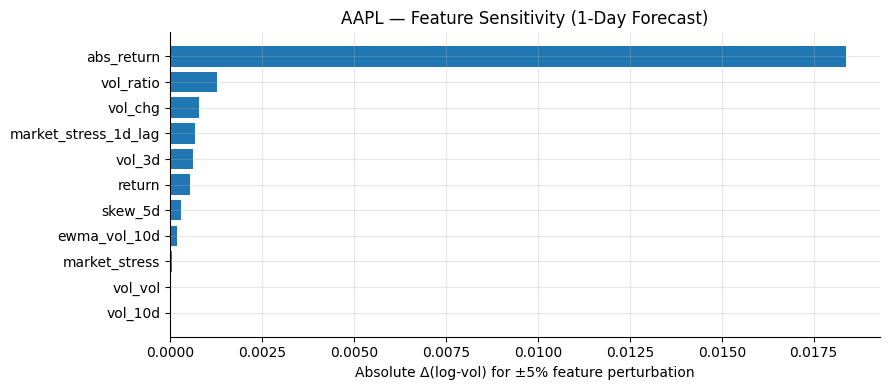

In [ ]:
feat_vals_1d = [abs(sensitivity[f]["1d"]) for f in feature_names]
order = np.argsort(-np.array(feat_vals_1d))

plt.figure(figsize=(9,4))
plt.barh([feature_names[i] for i in order], np.array(feat_vals_1d)[order])
plt.gca().invert_yaxis()
plt.title(f"{ticker} — Feature Sensitivity (1-Day Forecast)")
plt.xlabel("Absolute Δ(log-vol) for ±5% feature perturbation")
plt.tight_layout()
plt.show()

## Plot 5-day horizon sensitivity

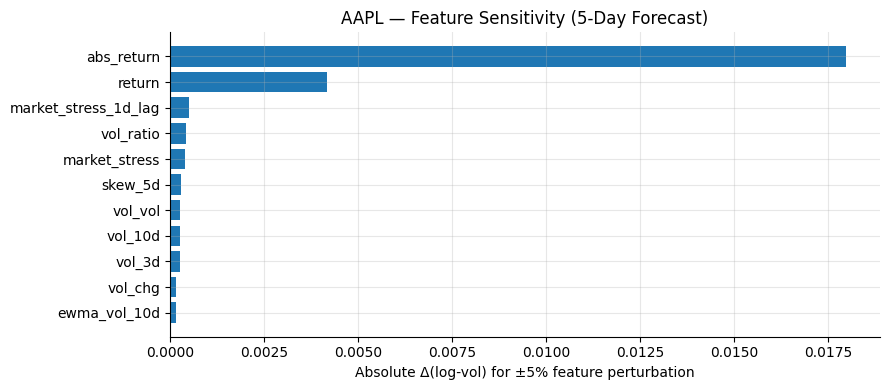

In [30]:
feat_vals_5d = [abs(sensitivity[f]["5d"]) for f in feature_names]
order = np.argsort(-np.array(feat_vals_5d))

plt.figure(figsize=(9,4))
plt.barh([feature_names[i] for i in order], np.array(feat_vals_5d)[order])
plt.gca().invert_yaxis()
plt.title(f"{ticker} — Feature Sensitivity (5-Day Forecast)")
plt.xlabel("Absolute Δ(log-vol) for ±5% feature perturbation")
plt.tight_layout()
plt.show()

## Plot 10-day horizon sensitivity

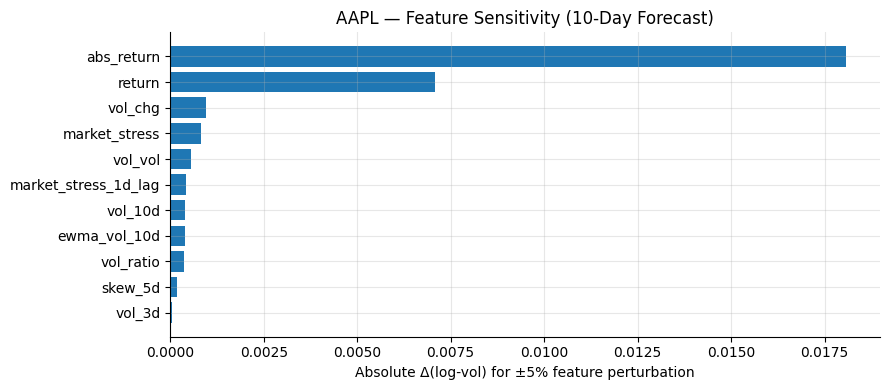

In [31]:
feat_vals_10d = [abs(sensitivity[f]["10d"]) for f in feature_names]
order = np.argsort(-np.array(feat_vals_10d))

plt.figure(figsize=(9,4))
plt.barh([feature_names[i] for i in order], np.array(feat_vals_10d)[order])
plt.gca().invert_yaxis()
plt.title(f"{ticker} — Feature Sensitivity (10-Day Forecast)")
plt.xlabel("Absolute Δ(log-vol) for ±5% feature perturbation")
plt.tight_layout()
plt.show()

## Attention heatmap extraction

In [28]:
def get_attention_heatmap(model, ticker_idx, x_input):
    model.eval()
    with torch.no_grad():
        X = model.feat_do(x_input)
        X = model.var_do(X)

        B, W, _ = X.shape
        emb = model.tok(ticker_idx).unsqueeze(1).expand(B, W, -1)
        X = torch.cat([X, emb], dim=-1)

        lstm_out, _ = model.lstm(X)
        batch_first = getattr(model.attn, "batch_first", False)

        if batch_first:
            attn_out, attn_weights = model.attn(
                lstm_out, lstm_out, lstm_out,
                need_weights=True,
                average_attn_weights=False
            )
        else:
            attn_in = lstm_out.transpose(0,1)
            attn_out, attn_weights = model.attn(
                attn_in, attn_in, attn_in,
                need_weights=True,
                average_attn_weights=False
            )
            attn_out = attn_out.transpose(0,1)

        attn_out = model.ln(attn_out)
        attn_w = attn_weights[0].cpu().numpy()  # [num_heads, W, W]
        return attn_w, np.arange(W)

attn_w, ts_idx = get_attention_heatmap(model, ticker_idx, x_input)
print("Attention shape:", attn_w.shape)


Attention shape: (4, 40, 40)


## Plot average attention

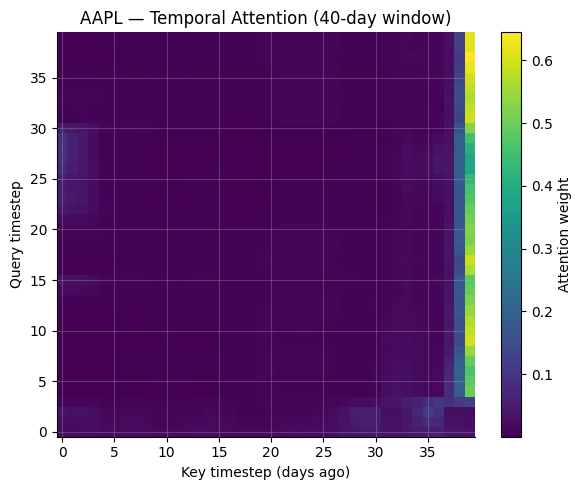

In [29]:
attn_avg = attn_w.mean(axis=0)
plt.figure(figsize=(6,5))
plt.imshow(attn_avg, aspect="auto", origin="lower", interpolation="nearest")
plt.colorbar(label="Attention weight")
plt.xlabel("Key timestep (days ago)")
plt.ylabel("Query timestep")
plt.title(f"{ticker} — Temporal Attention (40-day window)")
plt.tight_layout()
plt.show()

## Interpreting VolSense Explainability (Multi-Horizon View)

VolSense produces volatility forecasts at multiple horizons — 1-day, 5-day, and 10-day — each governed by its internal temporal attention and feature sensitivities.  
Together, these diagnostics provide an interpretable window into how the model learns market volatility structure.

---

### 1-Day Horizon – Short-Term Reactivity
- **Temporal Pattern:** Attention concentrates almost entirely in the last few timesteps (3–5 days), showing that immediate market moves dominate next-day volatility.
- **Feature Sensitivity:** `abs_return` overwhelmingly drives forecasts, confirming that realized return magnitude is the strongest short-term volatility catalyst.
- Smaller but non-negligible contributions from `vol_ratio` and `vol_chg` indicate that the model also tracks very short persistence in volatility bursts.

---

### 5-Day Horizon – Medium-Term Memory
- **Temporal Pattern:** Attention spreads across a wider 10-15-day window, revealing that the model begins integrating volatility clustering beyond the most recent week.
- **Feature Sensitivity:** Influence starts balancing between `abs_return` and smoother market descriptors such as `return`, `market_stress_1d_lag`, and `vol_ratio`.  
  This suggests the model internalizes both local shocks and decaying macro sentiment effects.

---

### 10-Day Horizon – Regime Awareness
- **Temporal Pattern:** Attention becomes more diffuse, covering a broader part of the full 40-day window.  
  The model now encodes longer-term volatility regimes rather than single-event reactions.
- **Feature Sensitivity:** `abs_return` and `return` remain influential, but `vol_chg`, `market_stress`, and lagged volatility measures grow in relative importance — indicating that forecasts are guided by sustained volatility trends rather than transient spikes.

---

Bear in mind that v109 and v507 were designed to be **short-term** volatility forecasters (use a 15-day rolling window for realized volatility). Experiments are ongoing for training and feature engineering for a wider range of volatility and horizon windows.

---

### Takeaways
1. **Dynamic Memory:** Attention adaptively widens with forecast horizon — from day-to-day shock response to multi-week regime tracking.  
2. **Feature Hierarchy:** Immediate realized returns drive near-term volatility, while structural and macro features dominate as the horizon extends.  
3. **Theory Alignment:** The learned dependencies align with empirical volatility behavior — short-term leptokurtic shocks evolve into long-memory clustering patterns.

> **Conclusion:**  
> VolSense’s internal explainability confirms that its LSTM-Attention backbone learns volatility dynamics in an economically consistent manner — *reactive in the short term, persistent in the medium term, and more regime-sensitive in the long term*.


## Single-feature temporal sensitivity analysis

Analyzing feature 'abs_return' (index=10) for horizons [1, 5, 10]-day


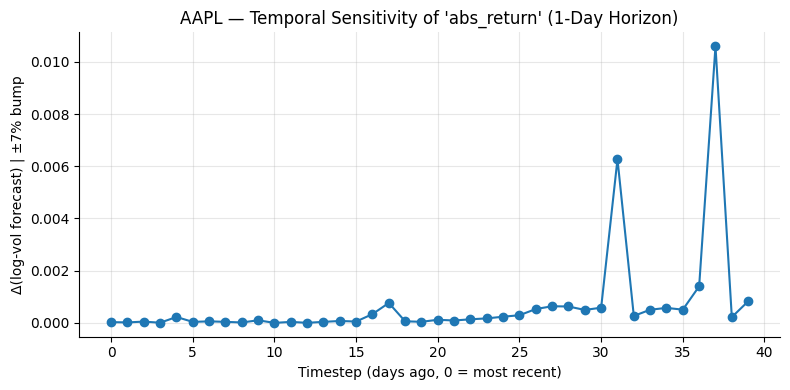

[1-day] Peak influence at timestep 37 (≈ 3 days ago) with Δ=0.01060


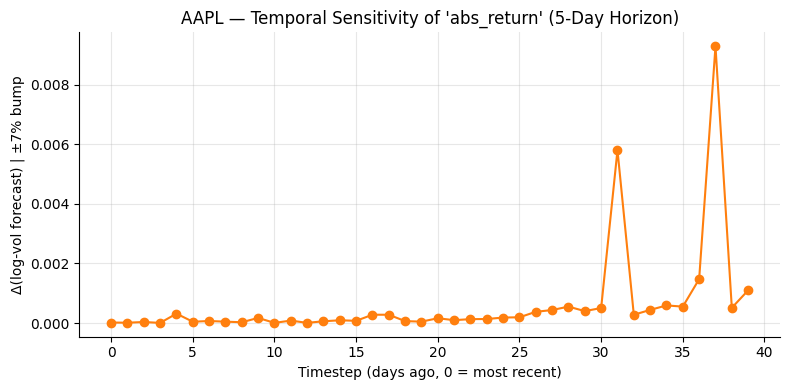

[5-day] Peak influence at timestep 37 (≈ 3 days ago) with Δ=0.00929


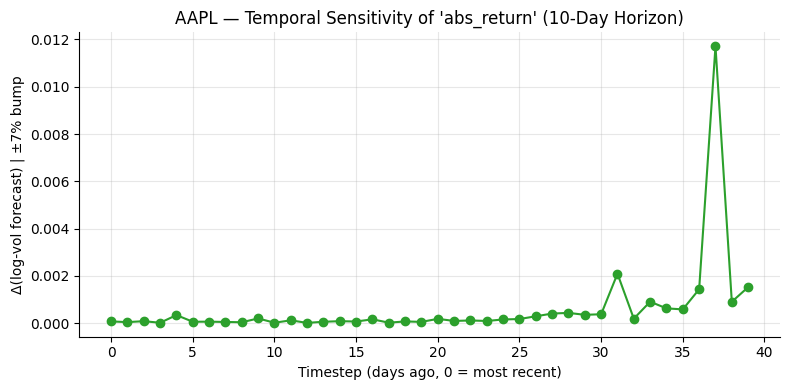

[10-day] Peak influence at timestep 37 (≈ 3 days ago) with Δ=0.01172


In [35]:
# ======================================================
#  Multi-horizon Temporal Sensitivity for a single feature
# ======================================================

# ---- Configurable knobs ----
FEATURE = "abs_return"          # choose any feature
PERTURB_PCT = 0.07              # ±5% perturbation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Feature index ----
feat_names = ["return"] + cfg.extra_features
feat_idx = feat_names.index(FEATURE)
print(f"Analyzing feature '{FEATURE}' (index={feat_idx}) for horizons {cfg.horizons}-day")

# ---- Base predictions for all horizons ----
with torch.no_grad():
    base_preds = model(ticker_idx, x_input).squeeze(0).cpu().numpy()  # shape: [num_horizons]

# ---- Loop over horizons ----
for h_i, horizon in enumerate(cfg.horizons):
    timesteps = np.arange(cfg.window)
    delta_effects = []

    for t in range(cfg.window):
        x_pert = x_input.clone().detach()

        # Apply bump at one timestep
        x_pert[0, t, feat_idx] *= (1 + PERTURB_PCT)

        with torch.no_grad():
            pert_pred = model(ticker_idx, x_pert).squeeze(0).cpu().numpy()[h_i]

        delta_effects.append(abs(pert_pred - base_preds[h_i]))

    # ---- Convert to numpy and plot ----
    delta_effects = np.array(delta_effects)
    plt.figure(figsize=(8, 4))
    plt.plot(range(cfg.window), delta_effects, marker='o', color=f"C{h_i}")
    plt.title(f"{ticker} — Temporal Sensitivity of '{FEATURE}' ({horizon}-Day Horizon)")
    plt.xlabel("Timestep (days ago, 0 = most recent)")
    plt.ylabel(f"Δ(log-vol forecast) | ±{PERTURB_PCT*100:.0f}% bump")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Report max sensitivity ----
    top_t = int(np.argmax(delta_effects))
    print(f"[{horizon}-day] Peak influence at timestep {top_t} (≈ {cfg.window - top_t} days ago) "
          f"with Δ={delta_effects[top_t]:.5f}")


## Temporal Sensitivity of `abs_return` Across Horizons

The plots above show how the forecasted log-volatility responds when the `abs_return` feature is perturbed by **±7%** at each point in the 40-day lookback window.  
Each curve corresponds to a different prediction horizon — 1-day, 5-day, and 10-day forecasts.

### Key Observations

1. **Recent shocks dominate**  
   Across all horizons, the model reacts most strongly to `abs_return` changes in the **last 3–5 days**.  
   This is expected: short-term realized volatility is heavily driven by recent absolute returns and large daily swings.

2. **Volatility memory decays over time**  
   Sensitivity fades rapidly as we move further back in the window.  
   By ~20–25 days ago, changes in `abs_return` have minimal influence.  
   This confirms that the model learns a **short-term volatility memory kernel** — a hallmark of realistic market behavior.

3. **Mid-range “aftershock” responses**  
   Smaller bumps appear around the 15–25-day region. These represent **persistence and volatility clustering**, where prior turbulence continues to slightly influence forecasts even after two weeks of calmer markets.

4. **Horizon-dependent smoothness**  
   - For the **1-day horizon**, peaks are sharp and localized, indicating rapid reactivity to recent returns.  
   - For **5-day** and **10-day horizons**, responses smooth out slightly — the model integrates recent shocks over a longer temporal horizon, reflecting how medium-term volatility forecasts are more “averaged” and less jumpy.

### Interpretation

This experiment demonstrates that:
- VolSense learns a **fast-decaying but non-zero volatility memory**, where most predictive power lies within the past week.
- The recency-weighted structure generalizes naturally across forecast horizons.
- The model aligns with empirical financial theory: **volatility clusters, then decays**.

Put simply:
> **VolSense’s volatility forecasts are driven primarily by recent market shocks, with a fading echo of past turbulence — precisely how real-world volatility behaves.**

---

**In summary:**  
The temporal sensitivity plots confirm that VolSense (v507) captures both the *reactive* and *persistent* components of volatility dynamics.  
When combined with the feature-level and attention-based analyses, this completes the explainability suite — showing *what* features matter, *when* they matter, and *how long* their effects persist.
